## 1. Setup and Imports

In [1]:
# Core libraries
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, 
    confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
)
from sklearn.preprocessing import LabelEncoder

# XGBoost
import xgboost as xgb

# Utilities
import joblib
from datetime import datetime
import os

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("All libraries imported successfully!")
print(f"XGBoost version: {xgb.__version__}")

All libraries imported successfully!
XGBoost version: 3.0.4


## 2. Load Engineered Data

In [2]:
# Load engineered datasets
train_df = pd.read_csv('data/data_minihackathon_train_engineered.csv')
test_df = pd.read_csv('data/data_minihackathon_test_engineered.csv')

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

print(f"\nOriginal 3-class distribution:")
print(train_df['drug_category'].value_counts())
print(f"\nPercentages:")
print(train_df['drug_category'].value_counts(normalize=True) * 100)

Train shape: (1500, 46)
Test shape: (377, 45)

Original 3-class distribution:
drug_category
Hallucinogens    691
Stimulants       567
Depressants      242
Name: count, dtype: int64

Percentages:
drug_category
Hallucinogens    46.066667
Stimulants       37.800000
Depressants      16.133333
Name: proportion, dtype: float64


## 3. Create Binary Labels: Depressants vs Others

In [3]:
# Separate features and target
X = train_df.drop(['drug_category', 'id'], axis=1, errors='ignore')
y_original = train_df['drug_category']
X_test = test_df.drop(['id'], axis=1, errors='ignore')
test_ids = test_df['id'] if 'id' in test_df.columns else np.arange(len(test_df))

# Create binary labels: 1 = Depressants, 0 = Others (Hallucinogens + Stimulants)
y_binary = (y_original == 'Depressants').astype(int)

print(f"\nBinary class distribution:")
print(f"  Depressants (1): {y_binary.sum()} ({y_binary.sum()/len(y_binary)*100:.2f}%)")
print(f"  Others (0): {(y_binary == 0).sum()} ({(y_binary == 0).sum()/len(y_binary)*100:.2f}%)")

print(f"\nFeatures shape: {X.shape}")
print(f"Test features shape: {X_test.shape}")
print(f"\nClass balance ratio: 1:{(y_binary == 0).sum() / y_binary.sum():.2f}")


Binary class distribution:
  Depressants (1): 242 (16.13%)
  Others (0): 1258 (83.87%)

Features shape: (1500, 45)
Test features shape: (377, 45)

Class balance ratio: 1:5.20


## 4. Cross-Validation Setup

In [4]:
# Configuration
N_FOLDS = 10
RANDOM_STATE = 42

# Stratified K-Fold for cross-validation
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

print(f"Using {N_FOLDS}-fold stratified cross-validation")
print(f"Random state: {RANDOM_STATE}")

Using 10-fold stratified cross-validation
Random state: 42


## 5. Train XGBoost Binary Classifier

In [5]:
%%time

print("\n" + "="*80)
print("Training XGBoost Binary Classifier (Depressants vs Others)")
print("="*80)

# Calculate scale_pos_weight for class imbalance
# scale_pos_weight = (number of negative class) / (number of positive class)
scale_pos_weight = (y_binary == 0).sum() / y_binary.sum()
print(f"\nScale pos weight (for imbalance): {scale_pos_weight:.2f}")

# XGBoost with balanced classes
xgb_binary = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    reg_alpha=0.5,
    reg_lambda=1.0,
    scale_pos_weight=scale_pos_weight,  # Handle class imbalance
    random_state=RANDOM_STATE,
    tree_method='hist',
    device='cpu',
    eval_metric='logloss'
)

# Cross-validation
scoring = ['accuracy', 'f1', 'precision', 'recall', 'roc_auc']
cv_results = cross_validate(
    xgb_binary, X, y_binary, cv=skf,
    scoring=scoring,
    return_train_score=True
)

print("\nCross-Validation Results:")
print(f"  Accuracy:  {cv_results['test_accuracy'].mean():.4f} ± {cv_results['test_accuracy'].std():.4f}")
print(f"  F1-Score:  {cv_results['test_f1'].mean():.4f} ± {cv_results['test_f1'].std():.4f}")
print(f"  Precision: {cv_results['test_precision'].mean():.4f} ± {cv_results['test_precision'].std():.4f}")
print(f"  Recall:    {cv_results['test_recall'].mean():.4f} ± {cv_results['test_recall'].std():.4f}")
print(f"  ROC AUC:   {cv_results['test_roc_auc'].mean():.4f} ± {cv_results['test_roc_auc'].std():.4f}")

print(f"\n{'='*80}")
print("CRITICAL METRICS FOR DEPRESSANTS DETECTION:")
print(f"  Recall (catch Depressants): {cv_results['test_recall'].mean():.2%}")
print(f"  Precision (avoid false positives): {cv_results['test_precision'].mean():.2%}")
print("="*80)


Training XGBoost Binary Classifier (Depressants vs Others)

Scale pos weight (for imbalance): 5.20

Cross-Validation Results:
  Accuracy:  0.8033 ± 0.0184
  F1-Score:  0.1198 ± 0.0955
  Precision: 0.2137 ± 0.1644
  Recall:    0.0863 ± 0.0743
  ROC AUC:   0.5794 ± 0.0628

CRITICAL METRICS FOR DEPRESSANTS DETECTION:
  Recall (catch Depressants): 8.63%
  Precision (avoid false positives): 21.37%
CPU times: total: 1min 48s
Wall time: 7.26 s

Cross-Validation Results:
  Accuracy:  0.8033 ± 0.0184
  F1-Score:  0.1198 ± 0.0955
  Precision: 0.2137 ± 0.1644
  Recall:    0.0863 ± 0.0743
  ROC AUC:   0.5794 ± 0.0628

CRITICAL METRICS FOR DEPRESSANTS DETECTION:
  Recall (catch Depressants): 8.63%
  Precision (avoid false positives): 21.37%
CPU times: total: 1min 48s
Wall time: 7.26 s


## 6. Train on Full Dataset

In [6]:
%%time

print("\n" + "="*80)
print("Training on Full Dataset")
print("="*80)

# Train on full training data
xgb_binary.fit(X, y_binary)

# Training predictions
train_pred = xgb_binary.predict(X)
train_pred_proba = xgb_binary.predict_proba(X)[:, 1]  # Probability of Depressants

# Metrics
train_accuracy = accuracy_score(y_binary, train_pred)
train_f1 = f1_score(y_binary, train_pred)
train_precision = f1_score(y_binary, train_pred, pos_label=1, average='binary')
train_recall = f1_score(y_binary, train_pred, pos_label=1, average='binary')
train_roc_auc = roc_auc_score(y_binary, train_pred_proba)

print(f"\nTraining Metrics:")
print(f"  Accuracy:  {train_accuracy:.4f}")
print(f"  F1-Score:  {train_f1:.4f}")
print(f"  ROC AUC:   {train_roc_auc:.4f}")

print(f"\nClassification Report (Training):")
print(classification_report(y_binary, train_pred, target_names=['Others', 'Depressants']))


Training on Full Dataset

Training Metrics:
  Accuracy:  1.0000
  F1-Score:  1.0000
  ROC AUC:   1.0000

Classification Report (Training):
              precision    recall  f1-score   support

      Others       1.00      1.00      1.00      1258
 Depressants       1.00      1.00      1.00       242

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500

CPU times: total: 10.8 s
Wall time: 690 ms

Training Metrics:
  Accuracy:  1.0000
  F1-Score:  1.0000
  ROC AUC:   1.0000

Classification Report (Training):
              precision    recall  f1-score   support

      Others       1.00      1.00      1.00      1258
 Depressants       1.00      1.00      1.00       242

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500

CPU times: total: 10.8 s
Wall time: 690 ms


## 7. Confusion Matrix and Visualizations

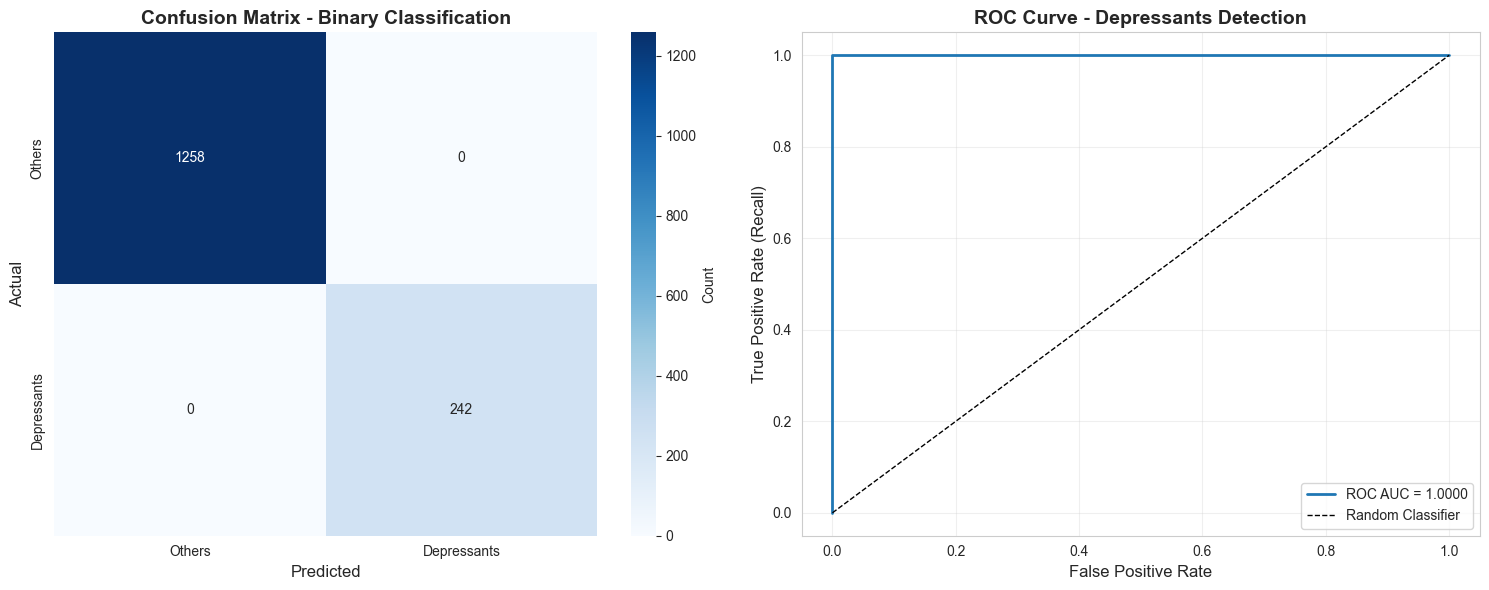

Visualization saved to: visualizations/binary_classification_metrics.png


In [7]:
# Create visualizations directory
os.makedirs('visualizations', exist_ok=True)

# Confusion matrix
cm = confusion_matrix(y_binary, train_pred)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Others', 'Depressants'], 
            yticklabels=['Others', 'Depressants'],
            cbar_kws={'label': 'Count'})
axes[0].set_title('Confusion Matrix - Binary Classification', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Actual', fontsize=12)
axes[0].set_xlabel('Predicted', fontsize=12)

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_binary, train_pred_proba)
axes[1].plot(fpr, tpr, linewidth=2, label=f'ROC AUC = {train_roc_auc:.4f}')
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
axes[1].set_xlabel('False Positive Rate', fontsize=12)
axes[1].set_ylabel('True Positive Rate (Recall)', fontsize=12)
axes[1].set_title('ROC Curve - Depressants Detection', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('visualizations/binary_classification_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualization saved to: visualizations/binary_classification_metrics.png")

## 8. Feature Importance for Depressants Detection

Top 20 Features for Detecting Depressants:
                  feature  importance
       Ethnicity_-0.31685    0.068452
          Impulsive_cubed    0.044782
         Country_-0.28519    0.030623
                   Oscore    0.030349
           Impulsive_x_SS    0.029509
       SS_to_Cscore_ratio    0.028626
             Nscore_cubed    0.028514
                Education    0.028288
Impulsive_to_Cscore_ratio    0.027226
              Cscore_x_SS    0.027021
                 OC_ratio    0.026911
               SS_squared    0.025617
                      Age    0.025063
                       ID    0.024995
           Gender_0.48246    0.024883
           HighRisk_Score    0.023970
      SensationRisk_Score    0.023476
                   Cscore    0.023357
       Oscore_x_Impulsive    0.023330
               NE_Balance    0.023018


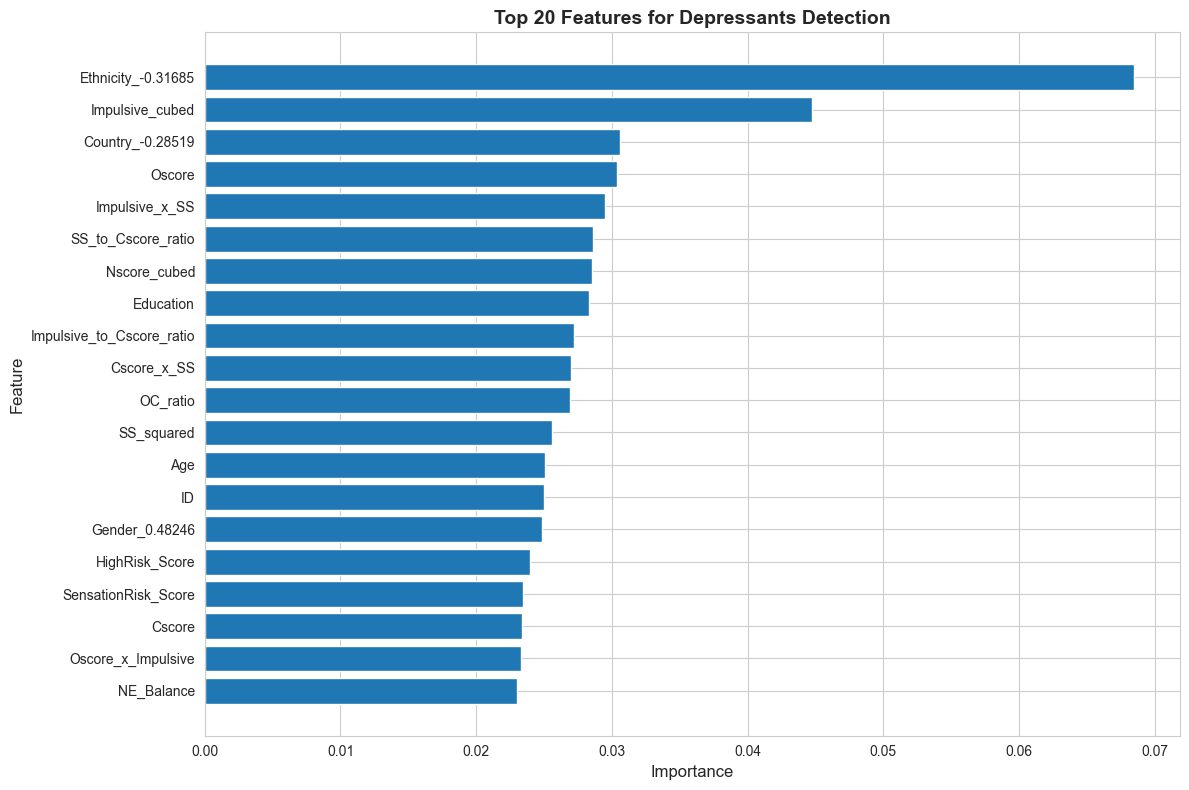


Feature importance saved to: visualizations/depressants_feature_importance.csv


In [8]:
# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_binary.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 20 Features for Detecting Depressants:")
print(feature_importance.head(20).to_string(index=False))

# Visualize top 20 features
plt.figure(figsize=(12, 8))
top_20 = feature_importance.head(20)
plt.barh(top_20['feature'], top_20['importance'])
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Top 20 Features for Depressants Detection', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('visualizations/depressants_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# Save full feature importance
feature_importance.to_csv('visualizations/depressants_feature_importance.csv', index=False)
print("\nFeature importance saved to: visualizations/depressants_feature_importance.csv")

## 9. Predict on Test Set

In [9]:
%%time

print("\n" + "="*80)
print("Predicting Depressants on Test Set")
print("="*80)

# Make predictions on test set
test_pred_binary = xgb_binary.predict(X_test)
test_pred_proba = xgb_binary.predict_proba(X_test)[:, 1]  # Probability of being Depressants

# Count predictions
n_depressants = test_pred_binary.sum()
n_others = (test_pred_binary == 0).sum()

print(f"\nTest Set Predictions:")
print(f"  Depressants: {n_depressants} ({n_depressants/len(test_pred_binary)*100:.2f}%)")
print(f"  Others: {n_others} ({n_others/len(test_pred_binary)*100:.2f}%)")

# Create results dataframe
results_df = pd.DataFrame({
    'id': test_ids,
    'is_depressant': test_pred_binary,
    'depressant_probability': test_pred_proba
})

# Sort by probability (most likely Depressants first)
results_df_sorted = results_df.sort_values('depressant_probability', ascending=False)

print(f"\n{'='*80}")
print("TOP 20 MOST LIKELY DEPRESSANTS (by probability):")
print("="*80)
print(results_df_sorted.head(20).to_string(index=False))

# Statistics on probabilities
print(f"\n{'='*80}")
print("DEPRESSANT PROBABILITY STATISTICS:")
print("="*80)
print(f"  Min probability: {test_pred_proba.min():.4f}")
print(f"  Max probability: {test_pred_proba.max():.4f}")
print(f"  Mean probability: {test_pred_proba.mean():.4f}")
print(f"  Median probability: {np.median(test_pred_proba):.4f}")
print(f"  Std probability: {test_pred_proba.std():.4f}")

# Samples with high confidence (>0.7)
high_confidence = results_df[results_df['depressant_probability'] > 0.7]
print(f"\n  High confidence Depressants (prob > 0.7): {len(high_confidence)}")
print(f"  Medium confidence Depressants (0.5 < prob <= 0.7): {len(results_df[(results_df['depressant_probability'] > 0.5) & (results_df['depressant_probability'] <= 0.7)])}")


Predicting Depressants on Test Set

Test Set Predictions:
  Depressants: 17 (4.51%)
  Others: 360 (95.49%)

TOP 20 MOST LIKELY DEPRESSANTS (by probability):
 id  is_depressant  depressant_probability
288              1                0.968960
350              1                0.833768
368              1                0.743884
141              1                0.718480
252              1                0.661625
 87              1                0.633939
297              1                0.623185
328              1                0.611649
318              1                0.609493
 89              1                0.573754
269              1                0.571189
 28              1                0.551973
 69              1                0.512706
213              1                0.509194
189              1                0.507144
212              1                0.504489
 29              1                0.503110
264              0                0.464479
220              0       

## 10. Visualize Test Predictions

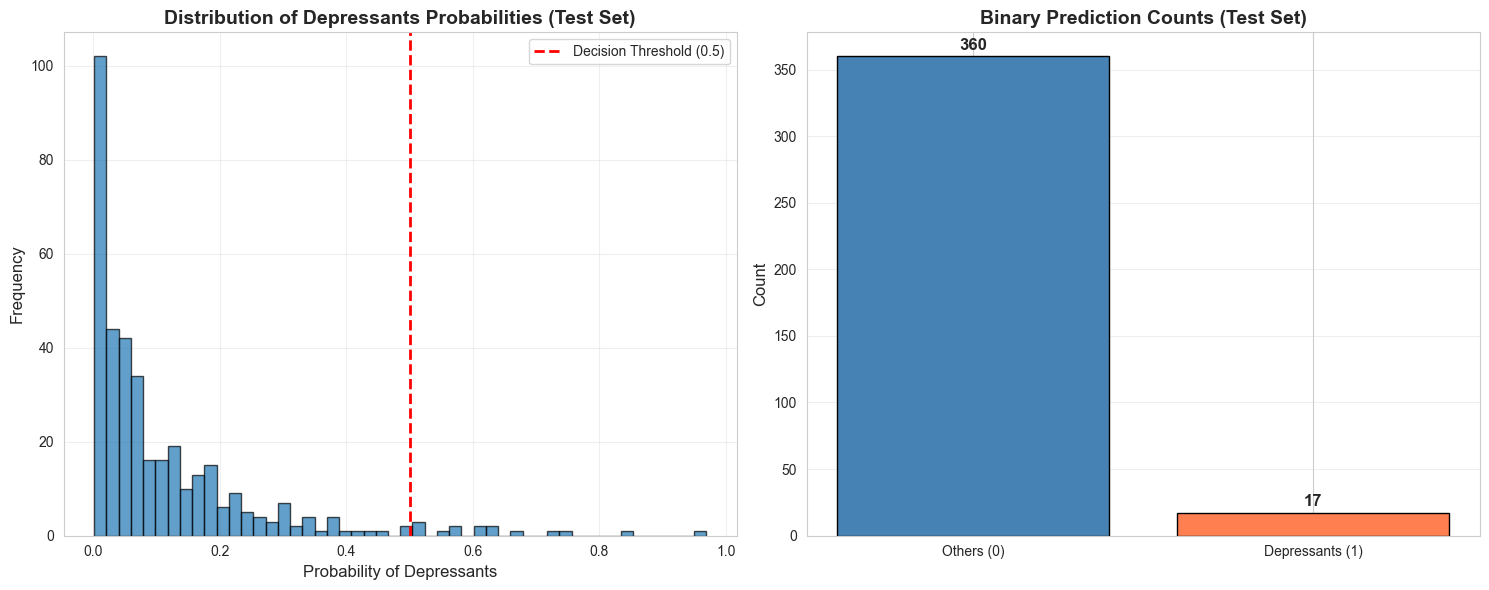

Visualization saved to: visualizations/test_predictions_distribution.png


In [10]:
# Probability distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Histogram of probabilities
axes[0].hist(test_pred_proba, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Decision Threshold (0.5)')
axes[0].set_xlabel('Probability of Depressants', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Depressants Probabilities (Test Set)', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Count plot
pred_counts = pd.Series(test_pred_binary).value_counts().sort_index()
axes[1].bar(['Others (0)', 'Depressants (1)'], pred_counts.values, color=['steelblue', 'coral'], edgecolor='black')
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title('Binary Prediction Counts (Test Set)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

# Add counts on bars
for i, v in enumerate(pred_counts.values):
    axes[1].text(i, v + 5, str(v), ha='center', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.savefig('visualizations/test_predictions_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualization saved to: visualizations/test_predictions_distribution.png")

## 11. Save Binary Predictions

In [11]:
# Create output directory
os.makedirs('binary_predictions', exist_ok=True)

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# Save full results with probabilities
results_filename = f"binary_predictions/depressants_predictions_{timestamp}.csv"
results_df.to_csv(results_filename, index=False)
print(f"Binary predictions saved: {results_filename}")

# Save sorted by probability
sorted_filename = f"binary_predictions/depressants_ranked_{timestamp}.csv"
results_df_sorted.to_csv(sorted_filename, index=False)
print(f"Ranked predictions saved: {sorted_filename}")

# Save only IDs predicted as Depressants
depressants_only = results_df[results_df['is_depressant'] == 1][['id', 'depressant_probability']]
depressants_filename = f"binary_predictions/depressants_ids_{timestamp}.csv"
depressants_only.to_csv(depressants_filename, index=False)
print(f"Depressants IDs saved: {depressants_filename}")

# Save model
os.makedirs('models', exist_ok=True)
model_filename = f"models/xgb_binary_depressants_{timestamp}.pkl"
joblib.dump(xgb_binary, model_filename)
print(f"\nModel saved: {model_filename}")

Binary predictions saved: binary_predictions/depressants_predictions_20251117_092724.csv
Ranked predictions saved: binary_predictions/depressants_ranked_20251117_092724.csv
Depressants IDs saved: binary_predictions/depressants_ids_20251117_092724.csv

Model saved: models/xgb_binary_depressants_20251117_092724.pkl


## 12. Create Simple Submission (Binary)

In [12]:
# Create simple binary submission
binary_submission = pd.DataFrame({
    'id': test_ids,
    'drug_category': ['Depressants' if pred == 1 else 'Others' for pred in test_pred_binary]
})

binary_submission_filename = f"submission_binary_{timestamp}.csv"
binary_submission.to_csv(binary_submission_filename, index=False)

print(f"\n{'='*80}")
print(f"BINARY SUBMISSION CREATED: {binary_submission_filename}")
print("="*80)
print(f"\nSubmission distribution:")
print(binary_submission['drug_category'].value_counts())
print(f"\nFirst 10 predictions:")
print(binary_submission.head(10).to_string(index=False))


BINARY SUBMISSION CREATED: submission_binary_20251117_092724.csv

Submission distribution:
drug_category
Others         360
Depressants     17
Name: count, dtype: int64

First 10 predictions:
 id drug_category
  0        Others
  1        Others
  2        Others
  3        Others
  4        Others
  5        Others
  6        Others
  7        Others
  8        Others
  9        Others


## 13. Summary and Recommendations

In [13]:
print("\n" + "="*80)
print("BINARY CLASSIFICATION SUMMARY")
print("="*80)

print(f"\n📊 PERFORMANCE METRICS:")
print(f"  ├─ CV Accuracy: {cv_results['test_accuracy'].mean():.4f} ± {cv_results['test_accuracy'].std():.4f}")
print(f"  ├─ CV F1-Score: {cv_results['test_f1'].mean():.4f} ± {cv_results['test_f1'].std():.4f}")
print(f"  ├─ CV Precision: {cv_results['test_precision'].mean():.4f}")
print(f"  ├─ CV Recall: {cv_results['test_recall'].mean():.4f}")
print(f"  └─ CV ROC AUC: {cv_results['test_roc_auc'].mean():.4f}")

print(f"\n🎯 TEST SET PREDICTIONS:")
print(f"  ├─ Total samples: {len(test_pred_binary)}")
print(f"  ├─ Predicted as Depressants: {n_depressants} ({n_depressants/len(test_pred_binary)*100:.2f}%)")
print(f"  ├─ Predicted as Others: {n_others} ({n_others/len(test_pred_binary)*100:.2f}%)")
print(f"  └─ High confidence (>0.7): {len(high_confidence)}")

print(f"\n📁 FILES GENERATED:")
print(f"  ├─ Binary predictions: {results_filename}")
print(f"  ├─ Ranked by probability: {sorted_filename}")
print(f"  ├─ Depressants IDs only: {depressants_filename}")
print(f"  ├─ Binary submission: {binary_submission_filename}")
print(f"  ├─ Model: {model_filename}")
print(f"  └─ Visualizations: visualizations/")

print(f"\n💡 HOW TO USE THESE RESULTS:")
print(f"  1. Use {depressants_filename} to see which IDs are likely Depressants")
print(f"  2. Use probability scores to adjust decision threshold if needed")
print(f"  3. Combine with 3-class predictions to fix missing Depressants")
print(f"  4. Check {sorted_filename} for confidence levels")

print(f"\n{'='*80}")
print("✅ BINARY CLASSIFICATION COMPLETE!")
print("="*80)


BINARY CLASSIFICATION SUMMARY

📊 PERFORMANCE METRICS:
  ├─ CV Accuracy: 0.8033 ± 0.0184
  ├─ CV F1-Score: 0.1198 ± 0.0955
  ├─ CV Precision: 0.2137
  ├─ CV Recall: 0.0863
  └─ CV ROC AUC: 0.5794

🎯 TEST SET PREDICTIONS:
  ├─ Total samples: 377
  ├─ Predicted as Depressants: 17 (4.51%)
  ├─ Predicted as Others: 360 (95.49%)
  └─ High confidence (>0.7): 4

📁 FILES GENERATED:
  ├─ Binary predictions: binary_predictions/depressants_predictions_20251117_092724.csv
  ├─ Ranked by probability: binary_predictions/depressants_ranked_20251117_092724.csv
  ├─ Depressants IDs only: binary_predictions/depressants_ids_20251117_092724.csv
  ├─ Binary submission: submission_binary_20251117_092724.csv
  ├─ Model: models/xgb_binary_depressants_20251117_092724.pkl
  └─ Visualizations: visualizations/

💡 HOW TO USE THESE RESULTS:
  1. Use binary_predictions/depressants_ids_20251117_092724.csv to see which IDs are likely Depressants
  2. Use probability scores to adjust decision threshold if needed
  3. C